In [10]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [13]:
cd drive/Projects/DCGAN

/content/drive/Projects/DCGAN


In [0]:
!mkdir images

In [0]:
!mkdir models_and_weights

In [15]:
!pip install tensorflow-gpu

In [0]:
from tensorflow.contrib.keras.api.keras.datasets import mnist
from tensorflow.contrib.keras.api.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.contrib.keras.api.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.contrib.keras.api.keras.layers import LeakyReLU
from tensorflow.contrib.keras.api.keras.layers import UpSampling2D, Conv2D
from tensorflow.contrib.keras.api.keras.models import Sequential, Model
from tensorflow.contrib.keras.api.keras.optimizers import Adam
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import matplotlib.pyplot as plt



weight_path="./models_and_weights/"

In [0]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        

        # Build the generator
        self.generator = self.build_generator()

        # load weight
        self.load_weights_from_file()
        
        # Compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
    
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()
#         (X_train, y_train) = mnist.train.images, mnist.train.labels
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        print(X_train.shape)
        X_train = np.reshape(X_train,(-1,28,28,1))

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                self.save_model()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()
        return
      
      # Save model
    def save_model(self):
        self.discriminator.save_weights(weight_path+'dcgan_discriminator_weight.h5')
        self.generator.save_weights(weight_path+'dcgan_generator_weight.h5')
        print("save model")
        
      # load weights  
    def load_weights_from_file(self):
        # discriminator weight
        if self.discriminator != None and os.path.isfile(weight_path+"dcgan_discriminator_weight.h5"):
          print("discriminator_weights exists")
          self.discriminator.load_weights(weight_path+"dcgan_discriminator_weight.h5")
        # generator weight   
        if self.generator != None and os.path.isfile(weight_path+"dcgan_generator_weight.h5"):
          print("generator_weights exists")
          self.generator.load_weights(weight_path+"dcgan_generator_weight.h5")

In [29]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [33]:
print(os.path.isfile(weight_path+"dcgan_generator_weight.h5"))

True


In [36]:
dcgan = DCGAN()
dcgan.train(epochs=3000, batch_size=1024, save_interval=100)
dcgan.save_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_v1_50 (B (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

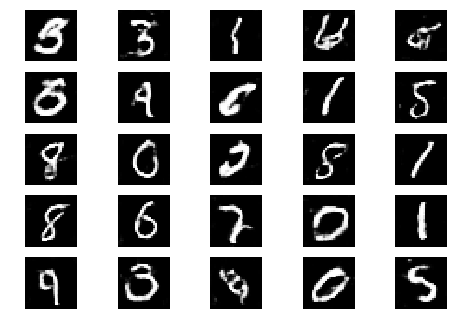

In [38]:
# Test out model

r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, 100))
gen_imgs = dcgan.generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
  for j in range(c):
    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
    axs[i,j].axis('off')
    cnt += 1